In [1]:
%matplotlib inline

import os; os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Flatten, Reshape, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
tokenizer = Tokenizer(lower=False)

texts = ['Hello there I how are you?', 'I am doing ok', 'Well WELL well, how about that']
tokenizer.fit_on_texts(texts)
tokenizer.texts_to_sequences(texts)

[[14, 9, 1, 2, 12, 13], [1, 10, 8, 5], [7, 11, 3, 2, 4, 6]]

In [3]:
# load the dataset, only keeping top n words...already tokenized
n_top_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=n_top_words)

In [13]:
embedding_length = 32  # Destination length of embedding seq
max_review_length = 256  # Limit the review to this length

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length, padding='post')
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length, padding='post')

X_train[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

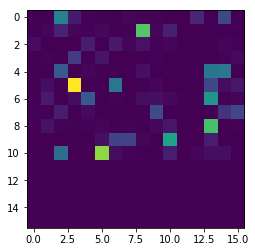

In [5]:
plt.imshow(X_train[np.random.randint(0, X_train.shape[0])].reshape((16, 16)))
plt.show()

In [12]:
input_data = Input(shape=(max_review_length,))
encoded = Embedding(n_top_words, embedding_length, input_length=max_review_length, mask_zero=True)(input_data)
encoded = LSTM(100)(encoded)
encoded = Dense(512, activation='relu')(encoded)

encoder = Model(input_data, encoded)  # Holds the layers that autoencoder trains

# Decoding layers
decoded = Dense(512, activation='relu')(encoded)
decoded = Reshape((1, 512))(decoded)
decoded = LSTM(100)(decoded)
decoded = Dense(max_review_length, activation='relu')(decoded)


# Model definition
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='rmsprop', loss='poisson')

print(autoencoder.summary())

history = autoencoder.fit(X_train, X_train,
                          epochs=10,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(X_test, X_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 256, 32)           320000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_14 (Dense)             (None, 512)               51712     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               245200    
__________

KeyboardInterrupt: 

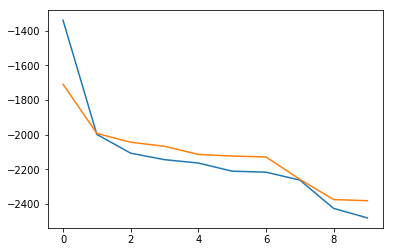

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [87]:
km = KMeans(n_clusters=2)
encoded_vals = encoder.predict(X_train)
p = km.fit_predict(encoded_vals)

In [88]:
print(classification_report(y_train, p, labels=[False, True]))

             precision    recall  f1-score   support

      False       0.50      0.65      0.57     12500
       True       0.51      0.36      0.42     12500

avg / total       0.50      0.50      0.49     25000



In [90]:
np.where(p == 1)[0].shape, np.where(y_train == 1)[0].shape

((8907,), (12500,))

(12500,)

In [77]:
# Layers
input_data = Input(batch_shape=(1, max_review_length))
x = Embedding(n_top_words, embedding_length, input_length=max_review_length)(input_data)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(128, return_sequences=False)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_data, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (1, 256)                  0         
_________________________________________________________________
embedding_22 (Embedding)     (1, 256, 32)              320000    
_________________________________________________________________
lstm_15 (LSTM)               (1, 256, 100)             53200     
_________________________________________________________________
lstm_16 (LSTM)               (1, 100)                  80400     
_________________________________________________________________
dense_6 (Dense)              (1, 1)                    101       
Total params: 453,701
Trainable params: 453,701
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
np.expand_dims(X_train, axis=1).shape

(25000, 1, 256)

In [44]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Train on 25000 samples, validate on 25000 samples
Epoch 1/3


KeyboardInterrupt: 